In [11]:
# Importing the drive module from google.colab library
from google.colab import drive

# Mounting the Google Drive to the Colab environment
drive.mount('/content/drive')

project_path = '/content/drive/My Drive/DEM_Aware_Downscaling/'

import os
os.chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import time
from utils.helpers_functions import read_dataset, z_score_normalize, denormalize_mae, mean_with_land_mask
from utils.models_functions import psnr, ssim, save_history, save_model, train_model, load_model
from utils.display_functions import plot_history, plot_to_compare, plot_per_pixel_metrics, plot_degrees_mae
from utils.evaluation_functions import evaluate_per_pixel

In [13]:
dem_path='/content/drive/My Drive/DEM_Aware_Downscaling/dem_data/'
dates_path='/content/drive/My Drive/MSc_Thesis/input_data/index/'
lr_data_path='/content/drive/My Drive/MSc_Thesis/input_data/deg/0_5x0_5/'
hr_data_path='/content/drive/My Drive/MSc_Thesis/input_data/deg/0_25x0_25/'
global_mean = 286.307980744908
global_Std = 64.2568020375484
target_size = (320, 580)

In [14]:
def compute_slope(dem, resolution_deg, lat_start=80, lat_end=0, lon_start=-60, lon_end=85):
    """
    Compute slope in radians from a 2D DEM (elevation in meters) using correct dx/dy scaling.

    Parameters:
        dem (ndarray): 2D elevation array of shape (320, 580)
        lat_start (float): latitude of first row (typically north)
        lat_end (float): latitude of last row (typically south)
        lon_start (float): longitude of first column (typically west)
        lon_end (float): longitude of last column (typically east)
        resolution_deg (float): spatial resolution in degrees (default: 0.25)

    Returns:
        slope (ndarray): 2D array of slope values in radians (same shape as input)
    """

    # Earth's radius approximation (in meters)
    R = 6371000

    nrows, ncols = dem.shape
    lats = np.linspace(lat_start, lat_end, nrows)  # from 80 to 0

    # Approximate dy = meridional distance between rows (constant)
    dy = resolution_deg * (np.pi / 180) * R  # in meters (~27.8 km)

    # Precompute dx for each latitude row (because dx varies with cos(latitude))
    dx = resolution_deg * (np.pi / 180) * R * np.cos(np.deg2rad(lats))  # 1D array, shape (nrows,)

    # Compute gradient in rows (y direction) and cols (x direction)
    dzdy = np.gradient(dem, axis=0) / dy  # shape (320, 580)
    dzdx = np.zeros_like(dem)

    for i in range(nrows):
        dzdx[i, :] = np.gradient(dem[i, :], edge_order=2) / dx[i]

    # Compute slope in radians
    slope = np.arctan(np.sqrt(dzdx**2 + dzdy**2))

    return slope

In [15]:
def compute_aspect(dem, cell_size=1.0):
    dzdx = np.gradient(dem, axis=1) / cell_size
    dzdy = np.gradient(dem, axis=0) / cell_size

    # Aspect in radians (0 = East, pi/2 = North)
    aspect = np.arctan2(-dzdy, dzdx)
    aspect = np.where(aspect < 0, 2 * np.pi + aspect, aspect)

    return aspect

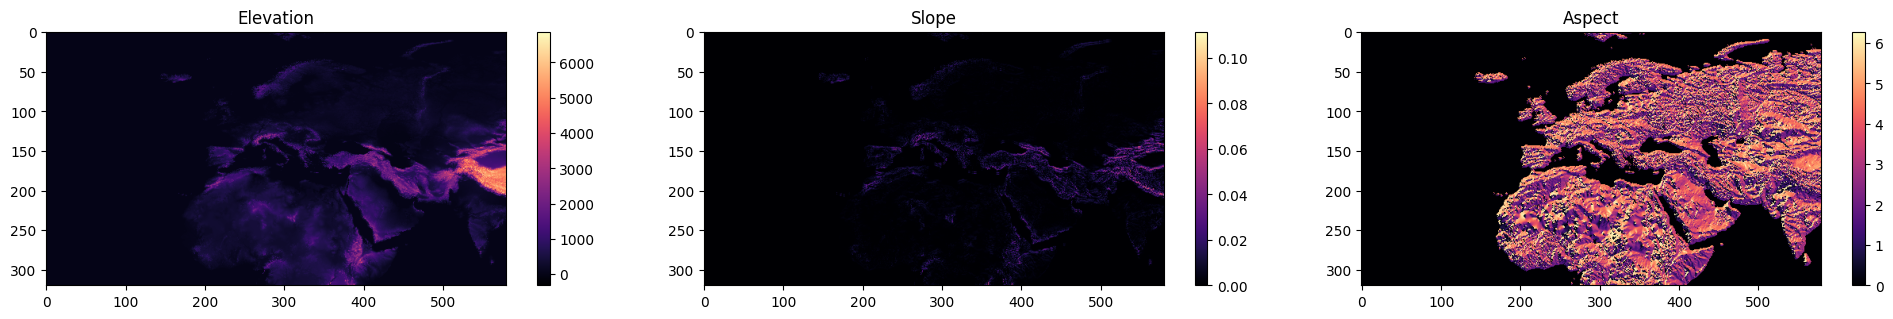

In [16]:
import matplotlib.pyplot as plt

dem_data_0_25 = np.load(dem_path+"dem_0_25.npy")
slope = compute_slope(dem_data_0_25, 0.25)
aspect = compute_aspect(dem_data_0_25)

plt.figure(figsize=(20, 3))

# Elevation
plt.subplot(1, 3, 1)
plt.title(f"Elevation")
plt.imshow(dem_data_0_25, cmap='magma')
plt.colorbar()

# Slope
plt.subplot(1, 3, 2)
plt.title(f"Slope")
plt.imshow(slope, cmap='magma')
plt.colorbar()

# Aspect
plt.subplot(1, 3, 3)
plt.title(f"Aspect")
plt.imshow(aspect, cmap='magma')
plt.colorbar()

plt.tight_layout()  # Ensures the subplots don't overlap
plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Add, LeakyReLU, Lambda, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model

# Load DEMs
dem_data_0_5 = np.load(dem_path + "dem_0_5.npy")
dem_data_0_25 = np.load(dem_path + "dem_0_25.npy")

# Compute slope
slope_0_5 = compute_slope(dem_data_0_5, 0.5)
slope_0_25 = compute_slope(dem_data_0_25, 0.25)

# Normalize all static features
slope_0_5 = z_score_normalize(slope_0_5, np.mean(slope_0_5), np.std(slope_0_5))
slope_0_25 = z_score_normalize(slope_0_25, np.mean(slope_0_25), np.std(slope_0_25))

# ---- Convert to Tensors and Expand ----
def to_tensor(x): return tf.expand_dims(tf.constant(x, dtype=tf.float32), axis=-1)

slope_tensor_0_5 = to_tensor(slope_0_5)
slope_tensor_0_25 = to_tensor(slope_0_25)

def expand_static_slope_0_5(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(slope_tensor_0_5, 0), [batch_size, 1, 1, 1])

def expand_static_slope_0_25(x):
    batch_size = tf.shape(x)[0]
    return tf.tile(tf.expand_dims(slope_tensor_0_25, 0), [batch_size, 1, 1, 1])

# ---- Residual Block ----
def residual_block(x, filters=32, kernel_size=3, scaling=0.1):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = LeakyReLU(alpha=0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = Lambda(lambda t: t * scaling)(res)
    return Add()([x, res])

# ---- Model ----
def create_edsr():
    input_img = Input(shape=(160, 290, 1))  # Low-resolution input

    # --- Low-Res Static Features (0.5°) ---
    static_low = Concatenate()([
        Lambda(expand_static_slope_0_5, output_shape=(160, 290, 1))(input_img)
    ])
    x = Concatenate()([input_img, static_low])

    # Initial Conv Layer
    initial_conv = Conv2D(filters=32, kernel_size=3, padding='same')(x)

    # Residual Blocks
    x = residual_block(initial_conv, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)
    x = residual_block(x, filters=32)

    x = Conv2D(filters=32, kernel_size=3, padding='same')(x)
    x = Add()([x, initial_conv])

    # Upsample (learned)
    x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)

    # --- High-Res Static Features (0.25°) ---
    static_high = Concatenate()([
        Lambda(expand_static_slope_0_25, output_shape=(320, 580, 1))(input_img)
    ])
    x = Concatenate()([x, static_high])

    # Fusion Layers
    # x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(x)
    # x = Conv2D(filters=8, kernel_size=3, padding='same', activation='relu')(x)

    # Final Conv Layer (Reduces to 1 Output Channel)
    output_img = Conv2D(filters=1, kernel_size=3, padding='same')(x)

    # Model Compilation
    model = Model(inputs=input_img, outputs=output_img)
    model.compile(optimizer='adam', loss='mae', metrics=[psnr, ssim, 'mse', 'mae'])

    return model

In [8]:
trainX, valX, testX, trainY, valY, testY, trainDates, valDates, testDates = read_dataset(dates_path, lr_data_path, hr_data_path, 'all', 2000, 2020, global_mean, global_Std)

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(21478, 160, 290, 1)
(21478, 320, 580, 1)
(4602, 160, 290, 1)
(4602, 320, 580, 1)
(4604, 160, 290, 1)
(4604, 320, 580, 1)


In [19]:
# Initialize the model
edsr_model = create_edsr()
edsr_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 290,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 160, 290,  │          0 │ input_layer_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 160, 290,  │          0 │ lambda_6[0][0]    │
│ (Concatenate)       │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 160, 290,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 2)                │            │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 160, 290,  │        608 │ concatenate_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 160, 290,  │      9,248 │ conv2d_13[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 160, 290,  │          0 │ conv2d_14[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 160, 290,  │      9,248 │ leaky_re_lu_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 160, 290,  │          0 │ conv2d_15[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 160, 290,  │          0 │ conv2d_13[0][0],  │
│                     │ 32)               │            │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 160, 290,  │      9,248 │ add_5[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 160, 290,  │          0 │ conv2d_16[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 160, 290,  │      9,248 │ leaky_re_lu_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 160, 290,  │          0 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 160, 290,  │          0 │ add_5[0][0],      │
│                     │ 32)               │            │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 160, 290,  │      9,248 │ add_6[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 160, 290,  │          0 │ conv2d_18[0][0] 

 Total params: 107,393 (419.50 KB)

 Trainable params: 107,393 (419.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 95s 131ms/step - loss: 0.0247 - mae: 0.0247 - mse: 0.0037 - psnr: 30.5194 - ssim: 0.8138 - val_loss: 0.0070 - val_mae: 0.0070 - val_mse: 1.4650e-04 - val_psnr: 38.3447 - val_ssim: 0.9691 - learning_rate: 0.0010
Epoch 2/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - loss: 0.0068 - mae: 0.0068 - mse: 1.2835e-04 - psnr: 39.0352 - ssim: 0.9724 - val_loss: 0.0066 - val_mae: 0.0066 - val_mse: 1.0298e-04 - val_psnr: 39.8757 - val_ssim: 0.9788 - learning_rate: 0.0010
Epoch 3/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 77s 115ms/step - loss: 0.0052 - mae: 0.0052 - mse: 7.2222e-05 - psnr: 41.4959 - ssim: 0.9830 - val_loss: 0.0037 - val_mae: 0.0037 - val_mse: 4.4689e-05 - val_psnr: 43.4991 - val_ssim: 0.9857 - learning_rate: 0.0010
Epoch 4/250
672/672 ━━━━━━━━━━━━━━━━━━━━ 77s 115ms/step - loss: 0.0046 - mae: 0.0046 - mse: 5.4573e-05 - psnr: 42.7189 - ssim: 0.9856 - val_loss: 0.0035 - val_mae: 0.0035 - val_mse: 3.8043e-05 - val_psnr: 44.1988 - val_ssim: 0.9872 - le

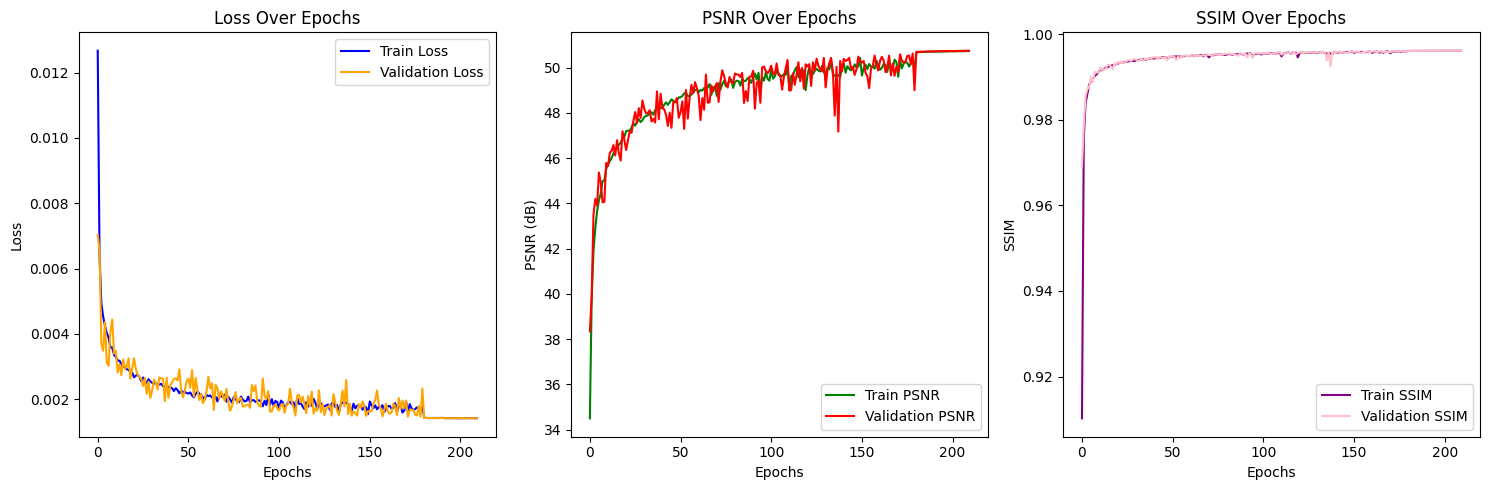

In [20]:
start_time = time.time()
history = train_model(edsr_model, trainX, trainY, valX, valY, 250, 32, True, True, 100, 70)
end_time = time.time()

# Print the time taken
print(f"Training time: {end_time - start_time:.2f} seconds")

save_history(history.history, 'models/history_0_5to0_25_deg_dem_4b.pkl')
plot_history(history.history)

save_model(edsr_model, 'models/edsr_model_0_5to0_25_deg_dem_4b.keras')

In [ ]:
edsr_model = tf.keras.models.load_model('models/edsr_model_0_5to0_25_deg_dem_4b.keras', custom_objects={
    'psnr': psnr,
    'ssim': ssim,
    'residual_block': residual_block,
    'expand_static_slope_0_5': expand_static_slope_0_5,
    'expand_static_slope_0_25': expand_static_slope_0_25
}, safe_mode=False)

In [21]:
test_loss, test_psnr, test_ssim, test_mse, test_mae = edsr_model.evaluate(testX, testY)

print(f"Test Loss: {test_loss}")
print(f"Test PSNR: {test_psnr}")
print(f"Test SSIM: {test_ssim}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

144/144 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 0.0014 - mae: 0.0014 - mse: 8.5116e-06 - psnr: 50.7093 - ssim: 0.9961
Test Loss: 0.0014248840743675828
Test PSNR: 50.714515686035156
Test SSIM: 0.9961282014846802
Test MSE: 8.501207958033774e-06
Test MAE: 0.0014248840743675828


In [22]:
low_res_input = testX[1]
high_res_data = testY[1]
high_res_output = edsr_model.predict(np.expand_dims(low_res_input, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


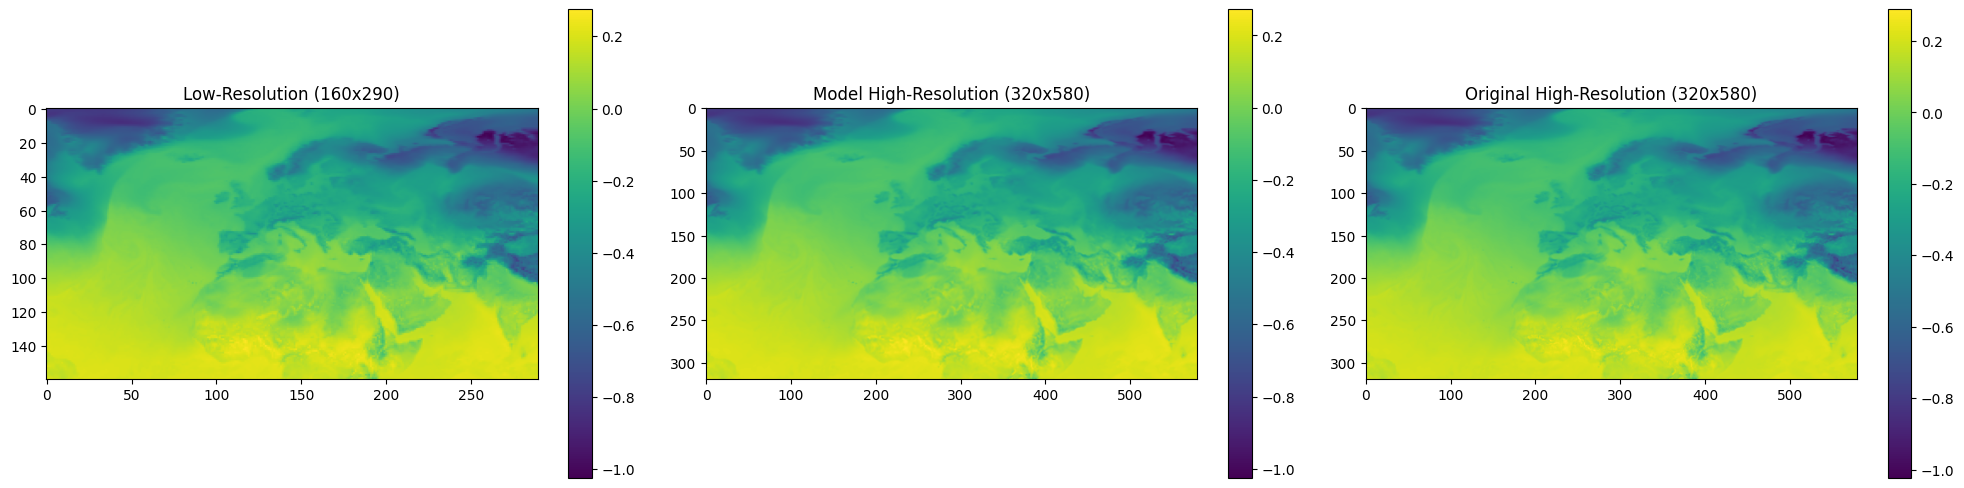

In [23]:
plot_to_compare(low_res_input, np.squeeze(high_res_data),  np.squeeze(high_res_output), 'viridis')

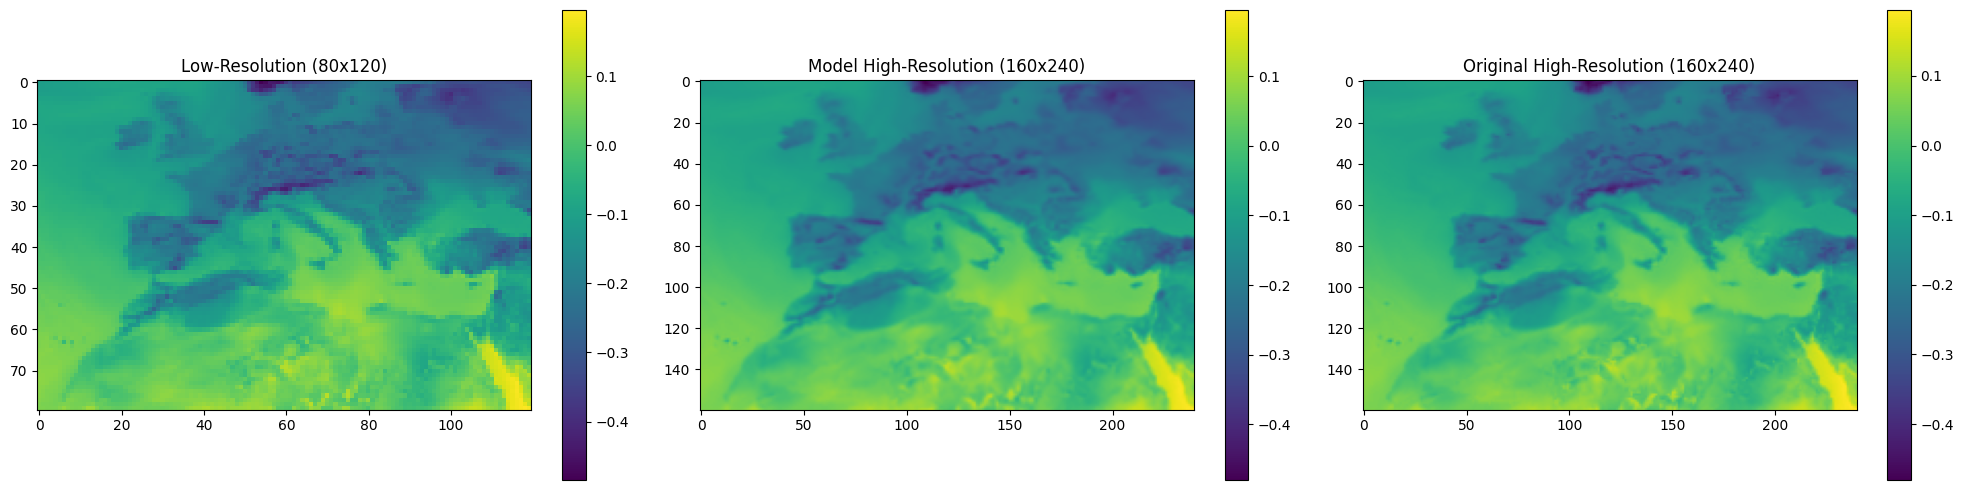

In [24]:
### Europe
plot_to_compare(low_res_input[40:120, 80:200], np.squeeze(high_res_data)[80:240, 160:400],  np.squeeze(high_res_output)[80:240, 160:400], 'viridis')

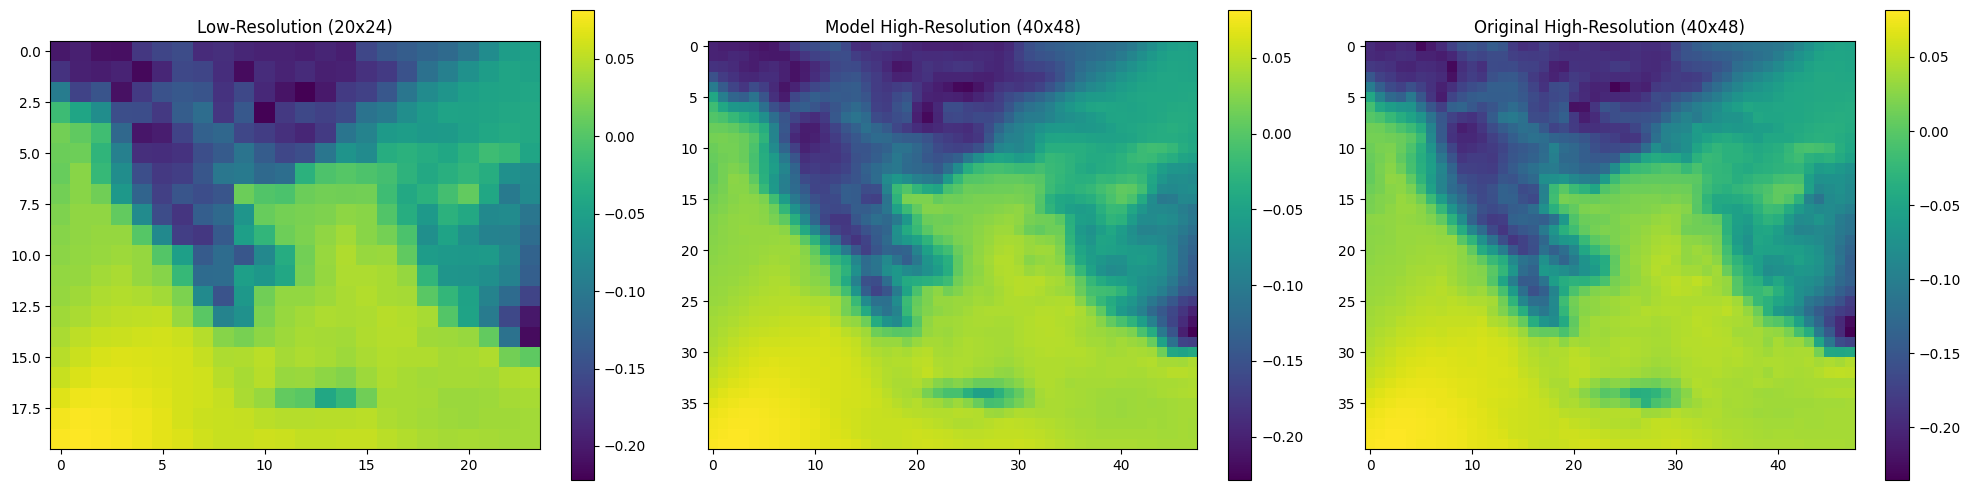

In [25]:
### Greece
plot_to_compare(low_res_input[72:92, 156:180], np.squeeze(high_res_data)[144:184, 312:360],  np.squeeze(high_res_output)[144:184, 312:360], 'viridis')

In [26]:
# Compute per-pixel metrics
test_mse, test_mae, test_psnr, test_ssim = evaluate_per_pixel(edsr_model, testX, testY)

print("Per-pixel MSE shape:", test_mse.shape)
print("Per-pixel MAE shape:", test_mae.shape)
print("Per-pixel PSNR shape:", test_psnr.shape)
print("Per-pixel SSIM shape:", test_ssim.shape)

mean_mse = np.mean(test_mse)
mean_mae = np.mean(test_mae)
mean_psnr = np.mean(test_psnr)
mean_ssim = np.mean(test_ssim)

print("Mean Per-Pixel MSE:", mean_mse)
print("Mean Per-Pixel MAE:", mean_mae)
print("Mean Per-Pixel PSNR:", mean_psnr)
print("Mean Per-Pixel SSIM:", mean_ssim)

144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step
Per-pixel MSE shape: (320, 580, 1)
Per-pixel MAE shape: (320, 580, 1)
Per-pixel PSNR shape: (320, 580, 1)
Per-pixel SSIM shape: (320, 580, 1)
Mean Per-Pixel MSE: 8.501206e-06
Mean Per-Pixel MAE: 0.0014248842
Mean Per-Pixel PSNR: 57.036865
Mean Per-Pixel SSIM: 0.9991059


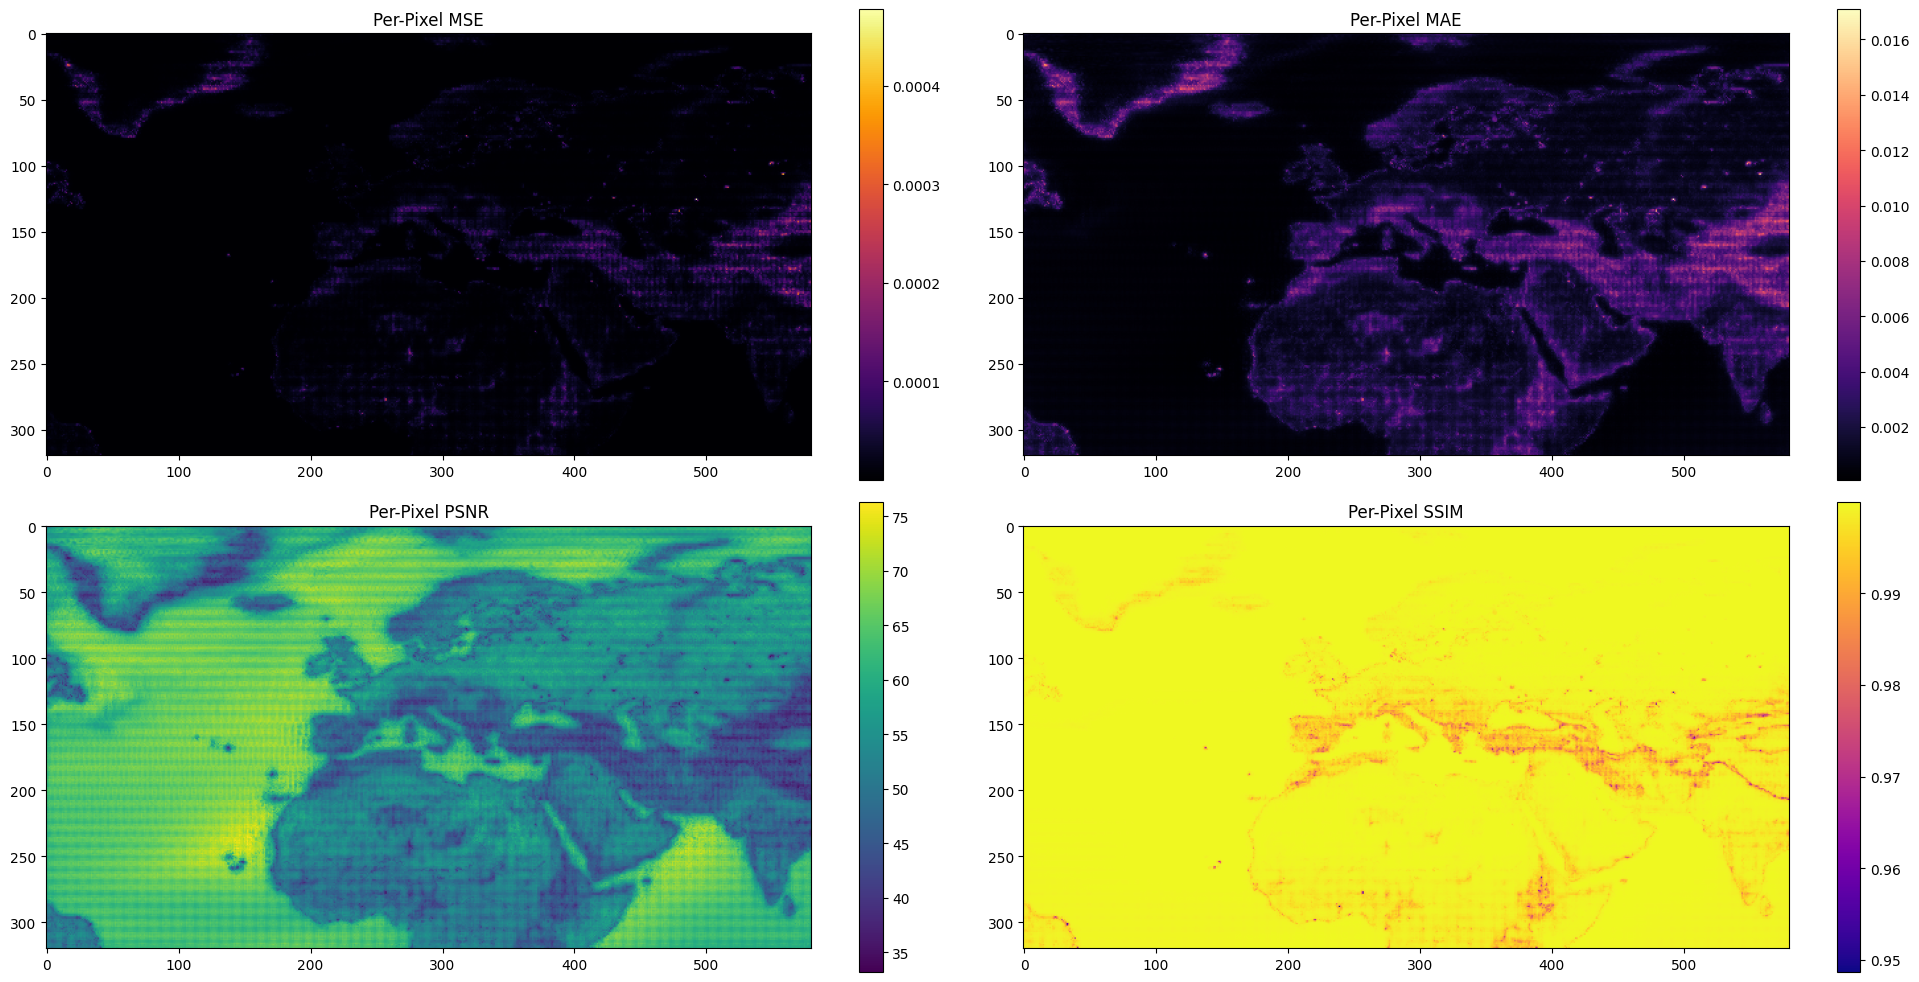

In [27]:
plot_per_pixel_metrics(test_mse, test_mae, test_psnr, test_ssim)

Mean Per-Pixel Degrees MAE: 0.0915585
Max Degrees MAE: 1.0987483
Min Degrees MAE: 0.0066369805


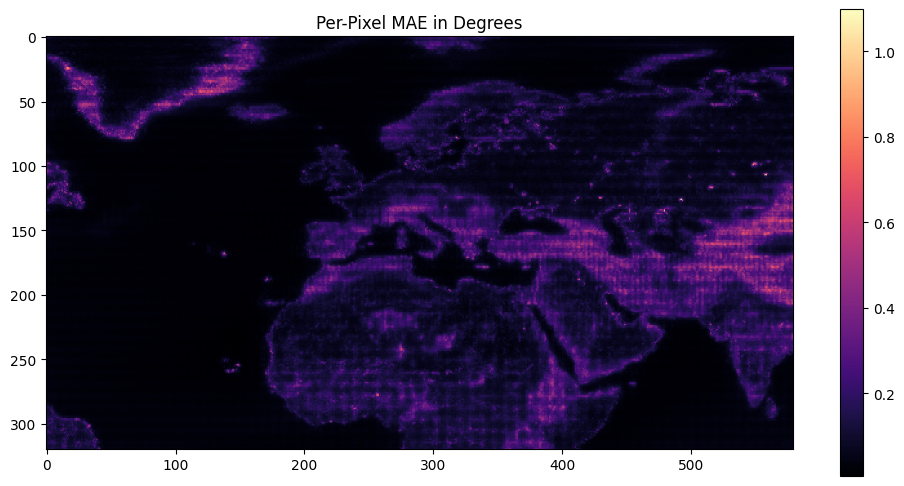

In [28]:
degrees_mae = denormalize_mae(test_mae, global_Std)
print("Mean Per-Pixel Degrees MAE:", np.mean(degrees_mae))
print("Max Degrees MAE:", degrees_mae.max())
print("Min Degrees MAE:", degrees_mae.min())
plot_degrees_mae(degrees_mae)

In [29]:
print("Mean Land-Pixels Degrees MAE:", mean_with_land_mask(degrees_mae, '0_25'))
print("Mean Land-Pixels MAE:", mean_with_land_mask(test_mae, '0_25'))

Mean Land-Pixels Degrees MAE: 0.14457208
Mean Land-Pixels MAE: 0.0022499112
